In [1]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

In [2]:
from hive_dataset import HiveDataset
from train import Train
from model import CNNModel
from modeling.model_transfer_learning import DenseNetTransferModel
from torchvision.models.densenet import DenseNet121_Weights
transforms_dense_net = DenseNet121_Weights.DEFAULT.transforms()

In [3]:
import config

metadata = np.load(config.PROCESSED_METADATA_FILE_SEGMENTED, allow_pickle=True)

metadata_column_names = ['sample_name', "label", "hive_number", "segment",]
metadata_df = pd.DataFrame(metadata, columns=metadata_column_names)
# metadata_df = metadata_df.astype({'label': 'int32', 'hive number': 'int32'})

metadata_df["sample_name"]

0       Hive1 12_06_2018_QueenBee____00_00_00
1       Hive1 12_06_2018_QueenBee____00_00_00
2       Hive1 12_06_2018_QueenBee____00_00_00
3       Hive1 12_06_2018_QueenBee____00_00_00
4       Hive1 12_06_2018_QueenBee____00_00_00
                        ...                  
5702    Hive3_28_07_2017_QueenBee____23_50_00
5703    Hive3_28_07_2017_QueenBee____23_50_00
5704    Hive3_28_07_2017_QueenBee____23_50_00
5705    Hive3_28_07_2017_QueenBee____23_50_00
5706    Hive3_28_07_2017_QueenBee____23_50_00
Name: sample_name, Length: 5707, dtype: object

In [5]:
trainer = Train()

label
0    2865
1    2842
Name: count, dtype: int64
Layer (type:depth-idx)                   Param #
CNNModel                                 --
├─Conv2d: 1-1                            160
├─Conv2d: 1-2                            4,640
├─Conv2d: 1-3                            18,496
├─Conv2d: 1-4                            73,856
├─MaxPool2d: 1-5                         --
├─Flatten: 1-6                           --
├─Linear: 1-7                            1,130,560
├─Linear: 1-8                            65
Total params: 1,227,777
Trainable params: 1,227,777
Non-trainable params: 0


In [5]:
trainer.train_cnn(epochs=1)

Training will happen on cuda.
EPOCH 1


100%|██████████| 125/125 [03:01<00:00,  1.45s/it]


LOSS train 0.686 valid 0.595


In [6]:
checkpoint_path = '../../models/interim/model_20240801_165801_0_checkpoint.pt'
model = CNNModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

model_loaded, optimizer, start_epoch, train_samples, val_samples, test_samples = trainer.load_model(checkpoint_path, model, optimizer)

In [7]:
model_loaded

CNNModel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=17664, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [8]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)

In [9]:
start_epoch

0

In [10]:
train_samples, val_samples, test_samples

(array(['Hive1 31_05_2018_NO_QueenBee____00_50_00',
        'Hive1 12_06_2018_QueenBee____20_40_00',
        'Hive3_28_07_2017_QueenBee____00_00_00',
        'Hive1 31_05_2018_NO_QueenBee____09_00_00',
        'Hive1 31_05_2018_NO_QueenBee____20_40_00',
        'Hive3_28_07_2017_QueenBee____03_20_00',
        'Hive3_28_07_2017_QueenBee____16_00_00',
        'Hive3_14_07_2017_NO_QueenBee____20_20_00',
        'Hive3_14_07_2017_NO_QueenBee____08_10_00',
        'Hive3_28_07_2017_QueenBee____16_20_00',
        'Hive3_28_07_2017_QueenBee____06_50_00',
        'Hive1 12_06_2018_QueenBee____19_00_00',
        'Hive1 12_06_2018_QueenBee____23_30_00',
        'Hive3_14_07_2017_NO_QueenBee____04_00_00',
        'Hive1 12_06_2018_QueenBee____01_10_00',
        'Hive3_28_07_2017_QueenBee____19_00_00',
        'Hive1 12_06_2018_QueenBee____03_10_00',
        'Hive1 31_05_2018_NO_QueenBee____04_50_00',
        'Hive3_14_07_2017_NO_QueenBee____21_40_00',
        'Hive1 12_06_2018_QueenBee____09_20_0

In [ ]:
file = '../../models/interim/model_20240704_154356_28.pt'
model = CNNModel()
model.load_state_dict(torch.load(file))

<All keys matched successfully>

In [ ]:
# model = trainer.model

In [ ]:
model.eval()

labels_test = []
predictions_test = []

with torch.no_grad():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Evaluation will happen on {device}.")
    model.to(device)

    for vdata in tqdm(trainer.test_dataloader):
        vinputs, vlabels = vdata
        vinputs, vlabels = vinputs.to(device), vlabels.to(device)
        voutputs = model(vinputs)
        labels_test.extend(vlabels)
        predictions_test.extend(voutputs)

labels_test = torch.stack(labels_test)
predictions_test = torch.stack(predictions_test)

print(labels_test.shape)

Evaluation will happen on cuda.


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:01<00:00,  1.52it/s]

torch.Size([43])


In [ ]:
labels_test

tensor([1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1.,
        0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1.,
        1., 1., 0., 0., 1., 0., 0.], device='cuda:0')

In [ ]:
predictions_test.cpu().numpy().squeeze().round()

array([1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0.,
       1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0.,
       1., 1., 1., 1., 1., 0., 1., 1., 0.], dtype=float32)

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted', ylabel='Actual'>

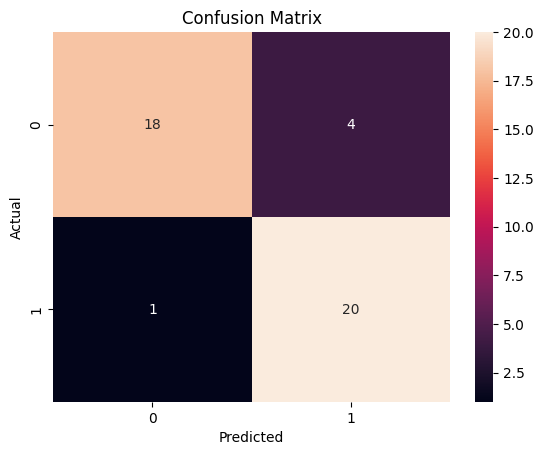

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sb

conf_matr = confusion_matrix(labels_test.cpu().numpy(), predictions_test.cpu().numpy().squeeze().round())
plt = sb.heatmap(conf_matr, annot=True, fmt='d')
plt.set_xlabel("Predicted")
plt.set_ylabel("Actual")
plt.set_title("Confusion Matrix")
plt

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(labels_test.cpu().numpy(), predictions_test.cpu().numpy().squeeze().round()))

              precision    recall  f1-score   support

         0.0       0.95      0.82      0.88        22
         1.0       0.83      0.95      0.89        21

    accuracy                           0.88        43
   macro avg       0.89      0.89      0.88        43
weighted avg       0.89      0.88      0.88        43

